In [118]:
import os
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
tf.test.gpu_device_name()
%load_ext autoreload
%autoreload 2


In [84]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import time
import functools
import IPython.display as display



In [4]:
def vgg_input_resize(path_to_img,new_width=244,new_height=244):
  img = PIL.Image.open(path_to_img)
  img = np.expand_dims(np.array(img.resize((new_width,new_height))),axis = 0)
  #plt.imshow(style_image)
  return img

def load_img(path_to_img,max_dim = 512):
  img = PIL.Image.open(path_to_img)
  width,height = img.size
  new_width,new_height = 0,0
  if width >= height:
    new_width = max_dim
    new_height = round(new_width/width*height)
  else:
    new_height = max_dim
    new_width = round(new_height/height*width)

  img = np.expand_dims(np.array(img.resize((new_width,new_height))),axis = 0)
  #plt.imshow(style_image)
  return img

# Create a simple function to display an image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  img = image.numpy()
  plt.imshow(image)
  if title:
    plt.title(title)


In [120]:
content_image = load_img('content_image/Shanghai.jpg')
style_image = load_img('style_image/van_gogh_star.jpeg')


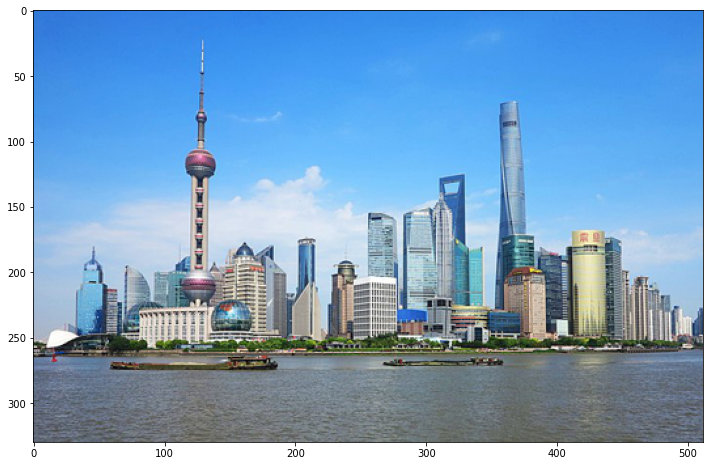

In [8]:
imshow(content_image)

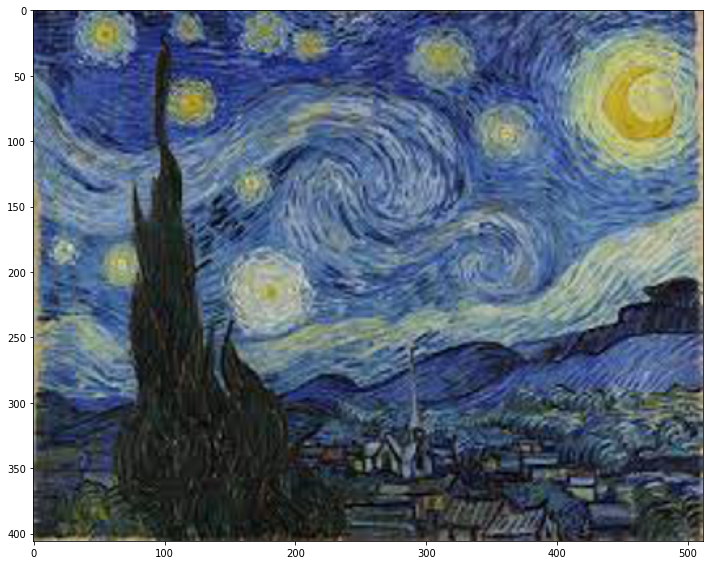

In [123]:
imshow(style_image)

In [124]:
vgg = tf.keras.applications.VGG16(include_top=True, weights='imagenet')


In [125]:
vgg = tf.keras.applications.VGG16(include_top=True, weights='imagenet')


In [126]:
prediction_probabilities = vgg(vgg_input_resize('content_image/Shanghai.jpg'))


In [155]:

'''# select block5 conv 2 as content layer
content_layers = ['block5_conv2'] 

# select the following layers as style layer
style_layers = ['block1_conv1',
          'block2_conv1',
          'block3_conv1', 
          'block4_conv1', 
          'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)'''
# select block5 conv 2 as content layer
content_layers = ['block2_conv2'] 

# select the following layers as style layer
style_layers = [
          'block3_conv1', 
          'block4_conv1', 
          'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [156]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  print(outputs)

  model = tf.keras.Model([vgg.input], outputs)
  return model


In [157]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image)


[<tf.Tensor 'block3_conv1_10/Identity:0' shape=(None, None, None, 256) dtype=float32>, <tf.Tensor 'block4_conv1_10/Identity:0' shape=(None, None, None, 512) dtype=float32>, <tf.Tensor 'block5_conv1_10/Identity:0' shape=(None, None, None, 512) dtype=float32>]


In [158]:
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())


block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7117.1885
  mean:  119.088005
block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  14898.467
  mean:  465.81918
block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3132.2373
  mean:  38.81911


In [159]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  #input_shape = tf.shape(input_tensor)
  #num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  #result/(num_locations)
  return result


In [160]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    #inputs = inputs*255.0
    #preprocessed_input = tf.keras.applications.vgg16.preprocess_input(inputs)
    #outputs = self.vgg(preprocessed_input)
    outputs = self.vgg(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                        outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
              for style_output in style_outputs]

    content_dict = {content_name:value 
              for content_name, value 
              in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
            for style_name, value
            in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}


In [161]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


[<tf.Tensor 'block3_conv1_11/Identity:0' shape=(None, None, None, 256) dtype=float32>, <tf.Tensor 'block4_conv1_11/Identity:0' shape=(None, None, None, 512) dtype=float32>, <tf.Tensor 'block5_conv1_11/Identity:0' shape=(None, None, None, 512) dtype=float32>, <tf.Tensor 'block2_conv2_11/Identity:0' shape=(None, None, None, 128) dtype=float32>]
Styles:
   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  10412801000.0
    mean:  285628000.0

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  36480283000.0
    mean:  1152736400.0

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  165878670.0
    mean:  2890472.2

Contents:
   block2_conv2
    shape:  (1, 165, 256, 128)
    min:  0.0
    max:  6054.6206
    mean:  129.85077


In [162]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image,dtype=tf.float32)


In [163]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def clip_0_255(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)


In [164]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [165]:

#style_weight=1e-2
#content_weight=1e4

#content_weight=10000
#style_weight=0.0001

def style_content_loss(outputs,content_weight=10000,style_weight=0.0001):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    # try different loss function
    
    return loss


In [166]:
plain_image = tf.Variable(np.random.normal(size=tuple(x for x in image.shape)),dtype=tf.float32)

plain_image


<tf.Variable 'Variable:0' shape=(1, 330, 512, 3) dtype=float32, numpy=
array([[[[-0.61520875, -0.20285039, -0.22942397],
         [-0.87018496,  1.7391509 ,  1.0490805 ],
         [-0.16149418,  1.9433256 ,  0.9800473 ],
         ...,
         [-1.7733352 , -1.7504666 , -0.6993113 ],
         [-0.19704576, -0.9232384 , -0.6293064 ],
         [ 0.6577687 ,  0.6492065 , -0.5615282 ]],

        [[-1.612902  , -1.3661449 ,  0.5583354 ],
         [ 1.8627311 ,  0.23888765,  1.2153782 ],
         [ 0.79402727,  1.1416428 ,  0.8379509 ],
         ...,
         [ 0.08715337, -0.58735305, -0.3086837 ],
         [ 0.30536118, -1.1578547 , -0.12381956],
         [-1.2333332 , -0.29724628,  0.8536828 ]],

        [[ 2.290303  , -0.40065414,  1.7598538 ],
         [-0.4943722 ,  0.83521986, -2.144231  ],
         [-0.3693935 ,  0.48645717, -0.05884637],
         ...,
         [ 0.4457031 , -0.14180127, -0.42029947],
         [ 0.4799403 ,  0.90934783, -1.2355452 ],
         [ 0.921142  , -0.2327751

In [167]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    print(output)
    loss = style_content_loss(outputs,0.01,100000)
    print(loss)

  grad = tape.gradient(loss, image)
  print(grad)
  opt.apply_gradients([(grad,image)])
  #image.assign(clip_0_1(image))
  image.assign(clip_0_255(image))



In [168]:
def tensor_to_image(tensor):
  #tensor = tensor*255
  print(tensor)
  tensor = tf.convert_to_tensor(tensor)
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)



In [169]:
image

<tf.Variable 'Variable:0' shape=(1, 330, 512, 3) dtype=float32, numpy=
array([[[[ 47., 120., 214.],
         [ 48., 121., 215.],
         [ 48., 121., 215.],
         ...,
         [ 51., 131., 224.],
         [ 52., 130., 222.],
         [ 55., 132., 224.]],

        [[ 48., 121., 215.],
         [ 48., 121., 215.],
         [ 48., 121., 215.],
         ...,
         [ 55., 134., 227.],
         [ 55., 133., 225.],
         [ 56., 133., 225.]],

        [[ 48., 121., 215.],
         [ 48., 121., 215.],
         [ 48., 121., 215.],
         ...,
         [ 56., 135., 228.],
         [ 55., 133., 226.],
         [ 56., 133., 225.]],

        ...,

        [[ 84.,  95., 110.],
         [ 90.,  99., 114.],
         [ 92., 101., 116.],
         ...,
         [ 68.,  79.,  97.],
         [ 70.,  81.,  94.],
         [ 79.,  88.,  97.]],

        [[ 90., 101., 115.],
         [100., 109., 124.],
         [ 97., 106., 121.],
         ...,
         [ 96., 107., 126.],
         [ 80.,  90., 103

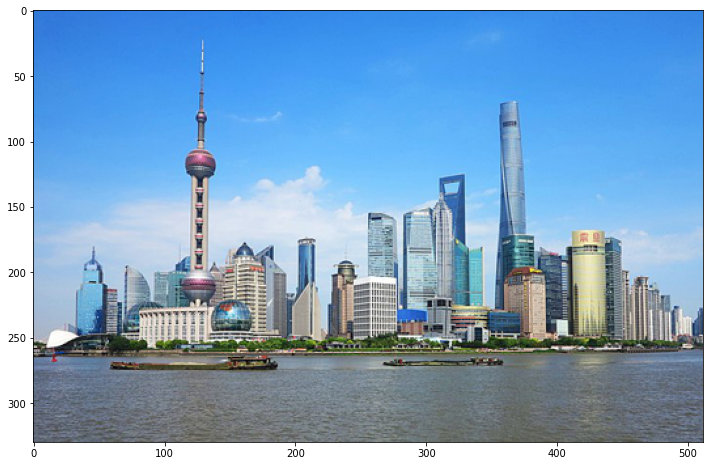

In [170]:
plt.imshow(np.squeeze(tf.cast(image,dtype=tf.int32).numpy()))


In [171]:
train_step(image)

tf.Tensor(
[[[[  53.17436    123.31327    287.40356   ...    0.
       0.           0.       ]
   [1162.1521       0.           0.        ...  425.99402
       0.           0.       ]
   [1240.3995      13.762383     0.        ...  362.13437
       0.           0.       ]
   ...
   [1291.2959     285.75916      0.        ...  376.887
       0.           0.       ]
   [1648.9303    1278.8408       0.        ...  422.8591
       0.           0.       ]
   [1442.59       358.95572      0.        ...  586.58136
       0.           0.       ]]

  [[   0.           0.         344.77124   ...    0.
     965.3614       0.       ]
   [ 524.36993      0.           0.        ...  480.77194
     359.32312    145.66049  ]
   [ 674.71686      0.           0.        ...  286.39917
      77.29547    340.73074  ]
   ...
   [ 710.52014      0.           0.        ...  315.2847
     393.9124     490.7401   ]
   [1303.1531    1368.352        0.        ...  388.50397
      58.83199    632.42633  ]
   [1562

<tf.Variable 'Variable:0' shape=(1, 330, 512, 3) dtype=float32, numpy=
array([[[[ 46.92    , 119.92002 , 213.91998 ],
         [ 47.92001 , 120.920006, 214.91998 ],
         [ 47.920372, 120.92009 , 214.92014 ],
         ...,
         [ 51.079823, 131.07619 , 224.07881 ],
         [ 52.0686  , 129.92104 , 221.94226 ],
         [ 54.92007 , 131.92009 , 223.92029 ]],

        [[ 47.92001 , 120.92002 , 214.91998 ],
         [ 47.92004 , 120.92004 , 214.92003 ],
         [ 47.921432, 120.9207  , 214.92062 ],
         ...,
         [ 54.920002, 133.92    , 226.92    ],
         [ 54.92    , 132.91998 , 224.91998 ],
         [ 55.920002, 132.91998 , 224.91998 ]],

        [[ 47.920166, 120.92015 , 214.92007 ],
         [ 47.92001 , 120.920006, 214.92    ],
         [ 48.04042 , 120.92269 , 214.92111 ],
         ...,
         [ 55.92006 , 134.92001 , 227.92001 ],
         [ 54.920033, 132.92001 , 225.92001 ],
         [ 55.920013, 132.92001 , 224.92    ]],

        ...,

        [[ 84.079994,

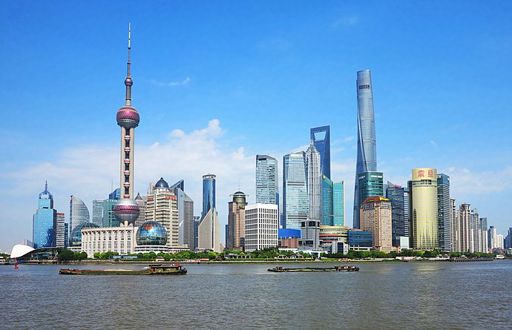

In [172]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)


In [173]:
plain_image = tf.Variable(np.random.normal(size=tuple(x for x in image.shape)),dtype=tf.float32)
image = tf.Variable(content_image,dtype=tf.float32)

<tf.Variable 'Variable:0' shape=(1, 330, 512, 3) dtype=float32, numpy=
array([[[[ 46.541977, 133.95705 , 204.9591  ],
         [ 38.764503, 113.565865, 203.77066 ],
         [ 45.24399 , 118.26947 , 205.89876 ],
         ...,
         [ 46.63454 , 127.23062 , 211.06952 ],
         [ 35.780525, 116.28139 , 201.71704 ],
         [ 41.07749 , 125.71636 , 207.40501 ]],

        [[ 41.468235, 118.127495, 200.5409  ],
         [ 39.969616, 113.53131 , 203.35466 ],
         [ 57.887024, 124.61489 , 205.89586 ],
         ...,
         [ 49.314747, 127.67146 , 215.54143 ],
         [ 40.98218 , 120.520996, 208.071   ],
         [ 40.454388, 120.175415, 207.05058 ]],

        [[ 44.33057 , 118.7219  , 191.73938 ],
         [ 39.656593, 111.29263 , 199.44157 ],
         [ 72.424225, 136.5604  , 199.11456 ],
         ...,
         [ 60.61982 , 130.16898 , 214.67728 ],
         [ 42.89577 , 120.126076, 208.10567 ],
         [ 41.32718 , 119.92841 , 206.26611 ]],

        ...,

        [[ 91.336205,

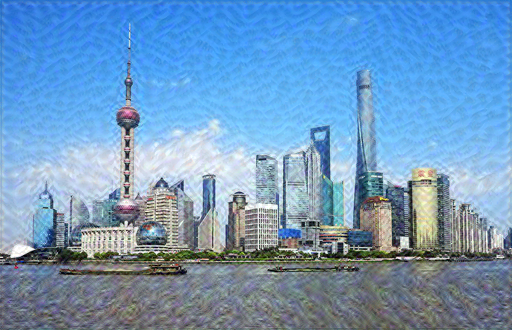

Train step: 1700
............................................................................

KeyboardInterrupt: 

In [174]:
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
